In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from time import time

from dataloader import ImageDataset
from model import *

np.random.seed(69)
torch.manual_seed(69)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f'Using: {device}')
if str(device) == 'cuda': print(torch.cuda.get_device_name()) 

Using: cpu


In [2]:
model_name = 'SRCNN4_best_195.pth'

test_set = ImageDataset("data/test/", 2)

# batch_size 1 for the proper PSNR calculation
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

# init model
model = SRCNN4()
model.to(device)

# loss function
loss_fn = nn.MSELoss()

checkpoint = torch.load('models/' + model_name, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

SRCNN4(
  (model): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [3]:
from utils import count_trainable

print(count_trainable(model))

154051


In [4]:
from math import log10
with torch.no_grad():
    t0 = time()
    test_loss = 0
    psnr = 0
    for batch in test_loader:
        # load data to the device
        x, y = batch[0].to(device), batch[1].to(device)
        out = model.forward(x)
        loss = loss_fn(out, y)
        test_loss += loss.item()
        psnr += 10 * log10(1 / loss.item())
    test_loss /= len(test_loader)
    psnr /= len(test_loader)
    print(f'PSNR: {psnr:.04f} | Loss: {test_loss:.06f} | Test time: {time()-t0:.2f}')

PSNR: 31.1708 | Loss: 0.001231 | Test time: 242.41


In [5]:
for batch in test_loader:
    # load data to the device
    x, y = batch[0].to(device), batch[1].to(device)
    out = model.forward(x)
    break
prediction = torch.permute(torch.squeeze(out), (1, 2, 0)).detach().cpu().numpy()
real = torch.permute(torch.squeeze(y), (1, 2, 0)).detach().cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


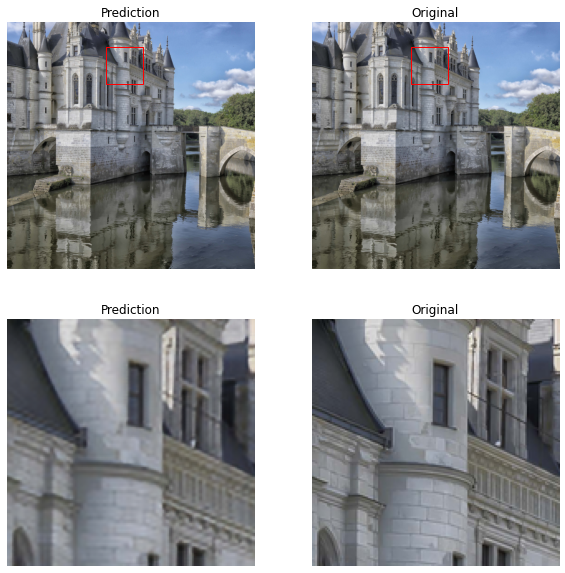

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from utils import save_plot

start1, end1 = 100, 250
start2, end2 = 400, 550

fig = plt.figure(figsize=(10,10))

plt.subplot(2, 2, 1)
plt.imshow(prediction)
plt.title('Prediction')
plt.axis('off')

ax = plt.gca()
rect = Rectangle((start2, start1), end2-start2, end1-start1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.subplot(2, 2, 2)
plt.imshow(real)
plt.title('Original')
plt.axis('off')

ax = plt.gca()
rect = Rectangle((start2, start1), end2-start2, end1-start1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.subplot(2, 2, 3)
plt.imshow(prediction[start1:end1, start2:end2, :])
plt.title('Prediction')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(real[start1:end1, start2:end2, :])
plt.title('Original')
plt.axis('off')
plt.show()

plt.show()
save_plot(fig, f'prediction_image')